# Gradient Boosting Regression – From Scratch

This notebook implements an optimized Gradient Boosting Regressor from scratch using decision trees and squared error loss.

## Imports

In [10]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [3]:

data_url = "http://lib.stat.cmu.edu/datasets/boston"

raw_df = pd.read_csv(
    data_url,
    sep=r"\s+",
    skiprows=22,
    header=None
)


X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


feature_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE",
    "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"
]

df = pd.DataFrame(X, columns=feature_names)
df["MEDV"] = y


print("Dataset Preview:")
df.head()


Dataset Preview:


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [14]:
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()


Dataset Shape: (506, 14)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [15]:
df.describe()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## Decision Tree Regressor (From Scratch)

In [5]:

class DecisionTreeRegressorScratch:
    def __init__(self, max_depth=3, min_samples_split=5, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.tree = None

    def fit(self, X, y):
        self.n_features = X.shape[1]
        self.tree = self._build_tree(X, y, depth=0)

    def _mse(self, y):
        return np.mean((y - np.mean(y)) ** 2)

    def _best_split(self, X, y):
        best_feature, best_threshold, best_loss = None, None, float("inf")
        features = np.random.choice(
            self.n_features,
            self.max_features or self.n_features,
            replace=False
        )

        for feature in features:
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left = X[:, feature] <= t
                right = X[:, feature] > t
                if left.sum() < self.min_samples_split or right.sum() < self.min_samples_split:
                    continue

                loss = self._mse(y[left]) * left.sum() + self._mse(y[right]) * right.sum()

                if loss < best_loss:
                    best_loss = loss
                    best_feature = feature
                    best_threshold = t

        return best_feature, best_threshold

    def _build_tree(self, X, y, depth):
        if depth >= self.max_depth or len(y) < self.min_samples_split:
            return np.mean(y)

        feature, threshold = self._best_split(X, y)
        if feature is None:
            return np.mean(y)

        left = X[:, feature] <= threshold
        right = X[:, feature] > threshold

        return {
            "feature": feature,
            "threshold": threshold,
            "left": self._build_tree(X[left], y[left], depth + 1),
            "right": self._build_tree(X[right], y[right], depth + 1),
        }

    def _predict_row(self, x, node):
        if not isinstance(node, dict):
            return node
        if x[node["feature"]] <= node["threshold"]:
            return self._predict_row(x, node["left"])
        return self._predict_row(x, node["right"])

    def predict(self, X):
        return np.array([self._predict_row(x, self.tree) for x in X])


## Gradient Boosting Regressor

In [6]:

class GradientBoostingRegressorScratch:
    def __init__(self, n_estimators=300, learning_rate=0.05, max_depth=4,
                 subsample=0.8, max_features=0.8, early_stopping_rounds=15):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.subsample = subsample
        self.max_features = max_features
        self.early_stopping_rounds = early_stopping_rounds
        self.models = []
        self.train_loss = []

    def fit(self, X, y):
        self.init_value = np.mean(y)
        y_pred = np.full_like(y, self.init_value)

        best_loss = float("inf")
        patience = 0

        for i in range(self.n_estimators):
            idx = np.random.choice(len(X), int(len(X) * self.subsample), replace=False)
            X_sub, y_sub = X[idx], y[idx]

            residuals = y_sub - y_pred[idx]

            tree = DecisionTreeRegressorScratch(
                max_depth=self.max_depth,
                max_features=int(X.shape[1] * self.max_features)
            )
            tree.fit(X_sub, residuals)

            y_pred += self.learning_rate * tree.predict(X)

            loss = np.mean((y - y_pred) ** 2)
            self.train_loss.append(loss)
            self.models.append(tree)

            if loss < best_loss:
                best_loss = loss
                patience = 0
            else:
                patience += 1
                if patience >= self.early_stopping_rounds:
                    break

    def predict(self, X):
        y_pred = np.full(X.shape[0], self.init_value)
        for tree in self.models:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred


## Train Model

In [7]:

model = GradientBoostingRegressorScratch(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    max_features=0.8,
    early_stopping_rounds=15
)

model.fit(X_train, y_train)


## Evaluate Model

In [8]:

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

print(f"Train RMSE: {train_rmse:.3f}")
print(f"Test RMSE : {test_rmse:.3f}")


Train RMSE: 0.868
Test RMSE : 2.890


## Training Loss Curve

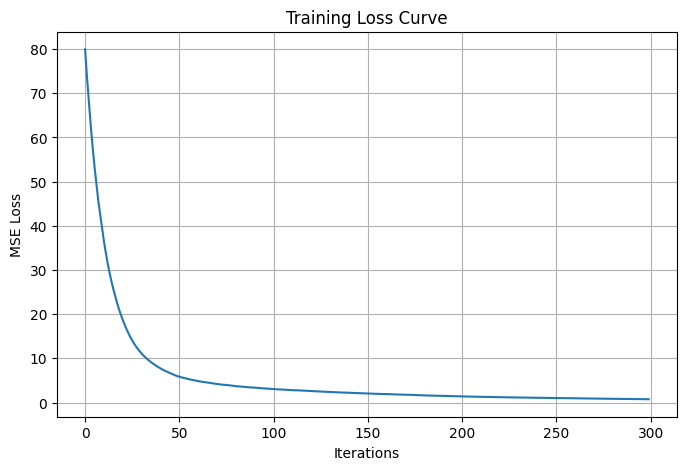

In [12]:

plt.figure(figsize=(8,5))
plt.plot(model.train_loss)
plt.xlabel("Iterations")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()


In [11]:

train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print(f"Train R² Score: {train_r2:.4f}")
print(f"Test R² Score : {test_r2:.4f}")


Train R² Score: 0.9913
Test R² Score : 0.8861
